Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».
В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.


Цель проекта: Постройте модель с максимально большим значением accuracy. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте accuracy на тестовой выборке самостоятельно.

импортируем библиотеки общего и специализированного назначения

In [1]:
from random import randint
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import os
import pandas as pd


Откройте файл с данными и изучите его. 

In [2]:
#

pth1 = '/datasets/users_behavior.csv'
pth2 = 'users_behavior.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1)
elif os.path.exists(pth2):
    df = pd.read_csv(pth2)
else:
    print('Something is wrong')

### Работа с данными



проверим данные

In [3]:
#
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Пропусков нет, названия столбцов корректные.

Целевым признаком в данном датасете является столбец данных is_ultra.

array([[<AxesSubplot:title={'center':'calls'}>,
        <AxesSubplot:title={'center':'minutes'}>],
       [<AxesSubplot:title={'center':'messages'}>,
        <AxesSubplot:title={'center':'mb_used'}>],
       [<AxesSubplot:title={'center':'is_ultra'}>, <AxesSubplot:>]],
      dtype=object)

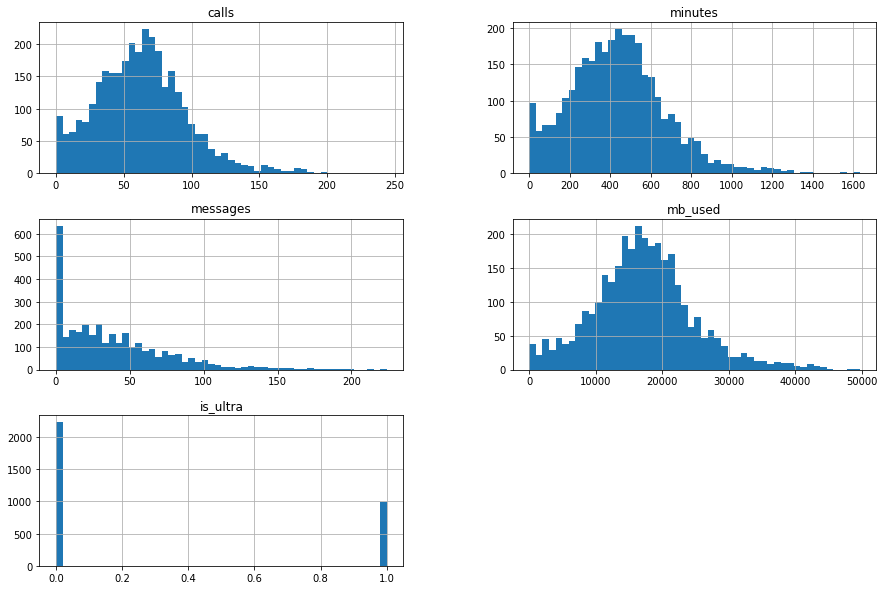

In [4]:
df.hist(bins=50, figsize=(15,10))

Данные распределены относительно нормально, что говорит о достаточном их количестве.

Наблюдается дисбаланс классов, количество "1" вдвое меньше чем "0".


Разделим исходные данные на обучающую, валидационную и тестовую выборки.

In [5]:
#


features_in = df.drop(['is_ultra'], axis=1)
target_in = df['is_ultra']

features, features_test, target, target_test = train_test_split(
   features_in, target_in, test_size=0.20, random_state=12345)


features_train, features_valid, target_train, target_valid = train_test_split(
   features, target, test_size=0.25, random_state=12345)



подготовим структуры для хранения итогов


In [6]:
# 
results = []

### Исследуйте качество разных моделей, меняя гиперпараметры. Кратко напишите выводы исследования.

GridSearchCV – это очень мощный инструмент для автоматического подбирания параметров для моделей машинного обучения. GridSearchCV находит наилучшие параметры, путем обычного перебора: он создает модель для каждой возможной комбинации параметров. Важно отметить, что такой подход может быть весьма времязатратным.

#### RandomForestRegressor Классификатор случайного леса

Определимся с параметрами:

n_estimators – число деревьев в лесу. Оно будет изменяться от 10 до 160 с шагом 10

max_depth – глубина дерева. Она будет изменяться от 1 до 12 с шагом в 2

min_samples_leaf – минимальное число образцов в листах. Оно будет изменяться от 1 до 7

min_samples_leaf – минимальное число образцов для сплита. Оно будет изменяться от 2 до 9.


In [8]:
clf = RandomForestClassifier()
rf_grid = { 'n_estimators': range (10, 161, 10),
              'max_depth': range (1,13, 2),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,2) }
scoring=['accuracy','f1']
model = GridSearchCV(clf, rf_grid, scoring = scoring, cv = 5,n_jobs=-1, refit = 'accuracy')# 
model.fit(features_train,target_train)


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(1, 13, 2),
                         'min_samples_leaf': range(1, 8),
                         'min_samples_split': range(2, 10, 2),
                         'n_estimators': range(10, 161, 10)},
             refit='accuracy', scoring=['accuracy', 'f1'])

Посмотрим на результат:

In [9]:
model.best_estimator_

RandomForestClassifier(max_depth=11, min_samples_leaf=7, min_samples_split=8,
                       n_estimators=110)

In [10]:
model.best_params_

{'max_depth': 11,
 'min_samples_leaf': 7,
 'min_samples_split': 8,
 'n_estimators': 110}

accuracy модели:

In [11]:
model.best_score_

0.8231357243792476

Сохраним модель и результаты для последующего анализа:

In [12]:
results.append(model)

##### Проверьте accuracy на тестовой выборке RandomForestClassifier 

In [13]:
model.score(features_test,target_test)

0.7962674961119751

####  DecisionTreeClassifier Классификатор дерева решений.

In [14]:
clf = DecisionTreeClassifier()
rf_grid = {'criterion':['gini','entropy'],
             'max_depth': np.arange(3, 50), 'min_samples_leaf':np.arange(2,10)}

scoring=['accuracy','f1']
model = GridSearchCV(clf, rf_grid, scoring = scoring, cv = 5,n_jobs=-1, refit = 'accuracy')# 
model.fit(features_train,target_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
                         'min_samples_leaf': array([2, 3, 4, 5, 6, 7, 8, 9])},
             refit='accuracy', scoring=['accuracy', 'f1'])

Посмотрим на результат:

In [15]:
model.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_leaf=9)

In [16]:
model.best_params_

{'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 9}

accuracy модели:

In [17]:
model.best_score_

0.8096413431128457

Сохраним модель и результаты для последующего анализа:

In [18]:
results.append(model)

##### Проверьте accuracy на тестовой выборке DecisionTreeClassifier

In [19]:
model.score(features_test,target_test)

0.7869362363919129

##### проверка на "вменяемость" 

In [20]:
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(features_train, target_train)

dummy_valid = dummy_clf.score(features_valid, target_valid)
dummy_test = dummy_clf.score(features_test, target_test)

print(f'Результат случайной модели на тестовой выборке: {dummy_test}')
print(f'Результат случайной модели на валидационной выборке: {dummy_valid}')

Результат случайной модели на тестовой выборке: 0.6951788491446346
Результат случайной модели на валидационной выборке: 0.6889580093312597


Этот классификатор(DummyClassifier) служит простой базой для сравнения с другими более сложными классификаторами.

Конкретное поведение базовой линии выбирается с помощью параметра стратегии.

Все стратегии делают прогнозы, которые игнорируют значения входных признаков, переданные в качестве аргумента X, для подгонки и прогнозирования. Прогнозы, однако, обычно зависят от значений, наблюдаемых в параметре y, переданном для обучения. 

Результат случайной модели на тестовой выборке равен примерно 70%, что подтверждает вменяемость всех рассмотренных моделей.

#### LogisticRegression Классификатор логической регрессии.

In [21]:
clf = LogisticRegression()
rf_grid = [{'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']},
              {'penalty':['none', 'elasticnet', 'l1', 'l2']},
              {'C':[0.001, 0.01, 0.1, 1, 10, 100]}]
scoring=['accuracy','f1'] 
model = GridSearchCV(clf, rf_grid, scoring = scoring, cv = 5,n_jobs=-1,refit ='accuracy')# 
model.fit(features_train,target_train)

/opt/conda/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:415: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.9/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_l

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                     'saga']},
                         {'penalty': ['none', 'elasticnet', 'l1', 'l2']},
                         {'C': [0.001, 0.01, 0.1, 1, 10, 100]}],
             refit='accuracy', scoring=['accuracy', 'f1'])

Посмотрим на результат:

In [22]:
model.best_estimator_

LogisticRegression(solver='newton-cg')

In [23]:
model.best_params_

{'solver': 'newton-cg'}

accuracy модели:

In [24]:
model.best_score_

0.7505201534217079

Сохраним модель и результаты для последующего анализа:

In [25]:
results.append(model)

##### Проверьте accuracy на тестовой выборке LogisticRegression

In [26]:
model.score(features_test,target_test)

0.7589424572317263

### выводы исследования

Преобразуем результат к читаемому виду

In [27]:

pd.set_option('display.max_colwidth', None)

df = pd.DataFrame(columns=['Classifier','Parameters','accuracy_valid','accuracy_test','f1'])


In [28]:
for idx,model in enumerate(results):
    a1=model.estimator
    a2=model.best_params_
    a3=results[idx].best_score_
    a4=model.score(features_test,target_test)
    a5=model.cv_results_['mean_test_f1'][0]
    df.loc[len(df.index)] = [a1, a2, a3, a4,a5]
display(df.sort_values(by='accuracy_test'))

,Classifier,Parameters,accuracy_valid,accuracy_test,f1
2,LogisticRegression(),{'solver': 'newton-cg'},0.750520,0.758942,0.370247
1,DecisionTreeClassifier(),"{'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 9}",0.809641,0.786936,0.615052
0,RandomForestClassifier(),"{'max_depth': 11, 'min_samples_leaf': 7, 'min_samples_split': 8, 'n_estimators': 110}",0.823136,0.796267,0.468690



Лучший результат по accuracy показала модель RandomForestClassifier, вторая по результату DecisionTreeClassifier.
Худший результат показала модель LinearRegression.
Это обусловлено особенностями входных данных и приспособленностью разных моделей, для задач соответствующей сложности.
Из результатов проведенных исследований видно, что для задач бинарной классификации, с несбалансированными классами и не нормализованными входными признаками больше других подходят модели на основе Деревьев решений и Градиентного бустинга.
Однако, если принимать в расчет соотношение точности и полноты(f1-mera) то модель на основе DecisionTreeClassifier выглядит предпочтительнее.